<a href="https://colab.research.google.com/github/gongbububu/gongbububu/blob/main/%EC%A0%84%EA%B7%B9%EA%B5%AC%EC%A1%B0%EB%AA%A8%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from math import pi

LFP 배치 위치: (7.12, 2.87), 반지름: 1.94, 기공률: 88.19%
LFP 배치 위치: (9.01, 9.04), 반지름: 1.89, 기공률: 76.43%
LFP 배치 위치: (2.01, 0.42), 반지름: 1.41, 기공률: 69.90%
LFP 배치 위치: (0.20, 4.56), 반지름: 1.80, 기공률: 59.20%
LFP 배치 위치: (3.86, 9.45), 반지름: 1.53, 기공률: 51.50%
LFP 배치 위치: (0.75, 9.69), 반지름: 1.32, 기공률: 45.74%
LFP 배치 위치: (3.61, 4.90), 반지름: 1.36, 기공률: 39.97%
LFP 배치 위치: (9.42, 5.71), 반지름: 1.27, 기공률: 34.65%
LFP 배치 위치: (8.98, -0.09), 반지름: 1.32, 기공률: 28.87%
LFP 배치 위치: (5.63, 6.79), 반지름: 1.27, 기공률: 23.77%
LFP 배치 위치: (5.19, 0.01), 반지름: 1.34, 기공률: 17.84%
Final porosity: 17.84%


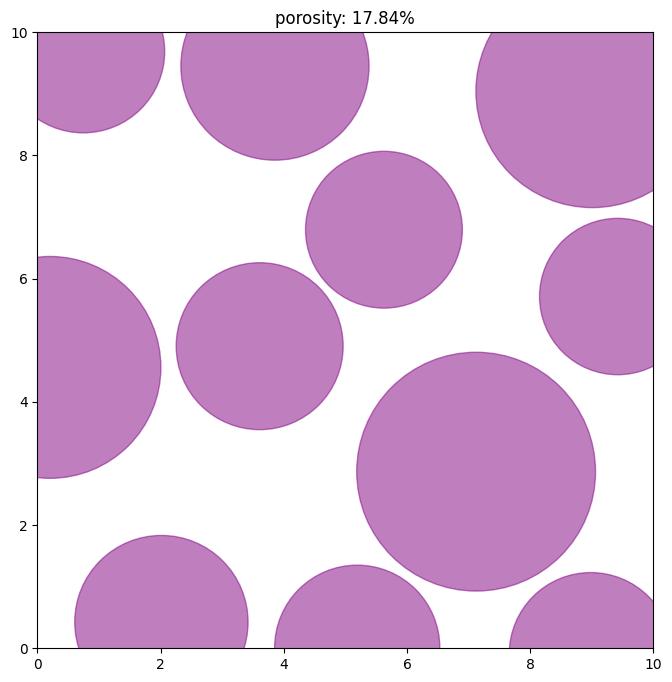

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from math import pi

# 랜덤 시드 고정
np.random.seed(3)

# 원의 면적 계산 함수 (잘린 원을 포함한 계산)
def circle_rect_area(x, y, r, domain_size):
    if 0 <= x - r and x + r <= domain_size and 0 <= y - r and y + r <= domain_size:
        return pi * r**2
    else:
        return pi * r**2 * 1.05

# LFP 배치 함수
def increase_radius_to_target_porosity(domain_size, min_r_LFP=1.25, max_r_LFP=2.5, target_porosity=0.2, max_attempts=10000):
    lfp_positions = []
    total_area = domain_size ** 2
    max_occupied_area = total_area * (1 - target_porosity)
    occupied_area = 0
    attempts = 0

    while occupied_area < max_occupied_area and attempts < max_attempts:
        r_LFP = np.random.uniform(min_r_LFP, max_r_LFP)
        x = np.random.uniform(-0.1, domain_size + 0.1)
        y = np.random.uniform(-0.1, domain_size + 0.1)

        overlap = False
        for lx, ly, lr in lfp_positions:
            dist = np.hypot(x - lx, y - ly)
            if dist < (r_LFP + lr) * 1.05:
                overlap = True
                break

        if not overlap:
            lfp_positions.append((x, y, r_LFP))
            occupied_area = sum(circle_rect_area(x, y, r, domain_size) for (x, y, r) in lfp_positions)
            print(f"LFP 배치 위치: ({x:.2f}, {y:.2f}), 반지름: {r_LFP:.2f}, 기공률: {1 - occupied_area / total_area:.2%}")

        attempts += 1

    while occupied_area < max_occupied_area and attempts < max_attempts:
        lfp_positions.sort(key=lambda x: x[2])

        for i in range(len(lfp_positions)):
            lx, ly, lr = lfp_positions[i]
            if lr < max_r_LFP:
                new_lr = lr + 0.07
                overlap = False
                for j in range(len(lfp_positions)):
                    if i != j:
                        lpx, lpy, lpr = lfp_positions[j]
                        dist = np.hypot(lx - lpx, ly - lpy)
                        if dist < (new_lr + lpr) * 1.05:
                            overlap = True
                            break

                if not overlap:
                    lfp_positions[i] = (lx, ly, new_lr)
                    occupied_area = sum(circle_rect_area(x, y, r, domain_size) for (x, y, r) in lfp_positions)
                    print(f"LFP 배치 위치: ({lx:.2f}, {ly:.2f}), 반지름: {new_lr:.2f}, 기공률: {1 - occupied_area / total_area:.2%}")

        attempts += 1

    occupied_area = sum(circle_rect_area(x, y, r_LFP, domain_size) for (x, y, r_LFP) in lfp_positions)
    porosity = 1 - occupied_area / total_area
    print(f"Final porosity: {porosity:.2%}")

    return lfp_positions

# 예시 사용
domain_size = 10
target_porosity = 0.1
lfp_positions = increase_radius_to_target_porosity(domain_size, target_porosity=target_porosity)

# 시각화
plt.figure(figsize=(8, 8))
for (lx, ly, lr) in lfp_positions:
    circle = patches.Circle((lx, ly), lr, color='purple', alpha=0.5)
    plt.gca().add_artist(circle)
plt.xlim(0, domain_size)
plt.ylim(0, domain_size)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(f"porosity: {1 - sum(circle_rect_area(x, y, r_LFP, domain_size) for (x, y, r_LFP) in lfp_positions) / (domain_size ** 2):.2%}")
plt.show()


In [ ]:
def place_cb_near_lfp(domain_size, lfp_positions, r_cb=0.1, target_cb_area_ratio=0.09, max_attempts=100000):
    cb_positions = []
    attempts = 0
    total_domain_area = domain_size ** 2
    target_cb_area = total_domain_area * target_cb_area_ratio
    single_cb_area = pi * r_cb ** 2
    accumulated_cb_area = 0

    while accumulated_cb_area < target_cb_area and attempts < max_attempts:
        # LFP 중 하나 선택
        lx, ly, lr = lfp_positions[np.random.randint(0, len(lfp_positions))]

        # LFP 경계 근처에 CB 배치 (거리: 반지름 + 0.05~0.2)
        angle = np.random.uniform(0, 2 * pi)
        distance_from_edge = np.random.uniform(r_cb , r_cb + 0.3)
        x = lx + (lr + distance_from_edge) * np.cos(angle)
        y = ly + (lr + distance_from_edge) * np.sin(angle)

        # 도메인 안에 있는지 확인
        if not (r_cb <= x <= domain_size - r_cb and r_cb <= y <= domain_size - r_cb):
            attempts += 1
            continue

        # LFP와 겹침 확인
        overlap = False
        for ox, oy, orad in lfp_positions:
            if np.hypot(x - ox, y - oy) < (r_cb + orad) * 1.0:
                overlap = True
                break

        # CB와 겹침 확인
        if not overlap:
            for cx, cy in cb_positions:
                if np.hypot(x - cx, y - cy) < 2 * r_cb * 1.0:
                    overlap = True
                    break

        if not overlap:
            cb_positions.append((x, y))
            accumulated_cb_area += single_cb_area

        attempts += 1

    print(f"CB 배치 완료: {len(cb_positions)}개, 누적 면적: {accumulated_cb_area:.2f}, 목표 면적: {target_cb_area:.2f}")
    return cb_positions


CB 배치 완료: 287개, 누적 면적: 9.02, 목표 면적: 9.00


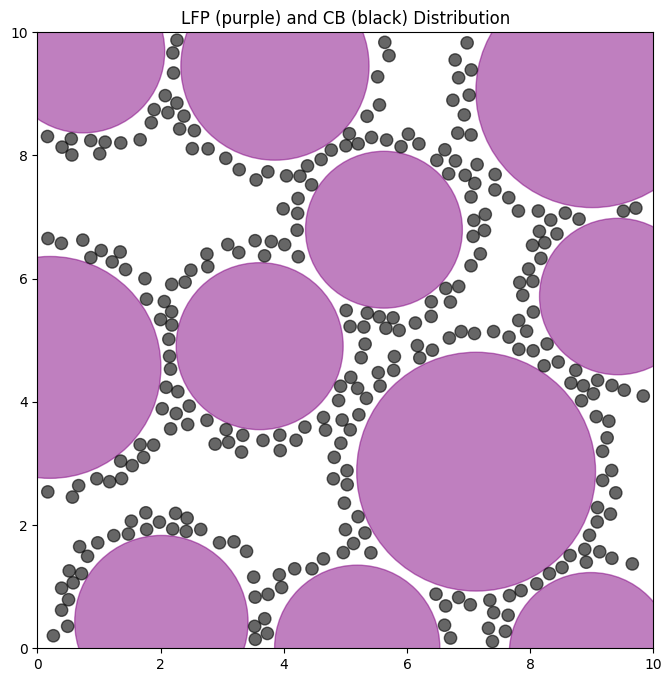

In [ ]:
np.random.seed(4)
cb_positions = place_cb_near_lfp(domain_size, lfp_positions, r_cb=0.1)

plt.figure(figsize=(8, 8))
ax = plt.gca()
for (lx, ly, lr) in lfp_positions:
    ax.add_patch(patches.Circle((lx, ly), lr, color='purple', alpha=0.5))
for (cx, cy) in cb_positions:
    ax.add_patch(patches.Circle((cx, cy), 0.1, color='black', alpha=0.6))
plt.xlim(0, domain_size)
plt.ylim(0, domain_size)
ax.set_aspect('equal', adjustable='box')
plt.title("LFP (purple) and CB (black) Distribution")
plt.show()


In [ ]:
lfp_array = np.array(lfp_positions)
cb_array = np.array(cb_positions)
print(lfp_array)
print('-----')
print(cb_array)

[[ 7.12310779e+00  2.86722834e+00  1.93849738e+00]
 [ 9.00805893e+00  9.04218951e+00  1.88853451e+00]
 [ 2.01387736e+00  4.24965474e-01  1.40698164e+00]
 [ 2.04737351e-01  4.55969889e+00  1.80101230e+00]
 [ 3.85730683e+00  9.45111323e+00  1.52744735e+00]
 [ 7.45284392e-01  9.68901331e+00  1.32216436e+00]
 [ 3.60906545e+00  4.90418836e+00  1.35527706e+00]
 [ 9.42170898e+00  5.71021626e+00  1.26952940e+00]
 [ 8.98440049e+00 -9.47772860e-02  1.32416406e+00]
 [ 5.62664742e+00  6.79481456e+00  1.27313961e+00]
 [ 5.19281644e+00  8.78117280e-03  1.34089082e+00]]
-----
[[0.89873593 1.49188493]
 [7.00652596 5.93997599]
 [1.51467615 3.10149276]
 [0.64560198 8.14661341]
 [0.44217062 8.20264001]
 [7.00523574 9.70078951]
 [5.14840959 3.86100457]
 [7.22585279 7.92680469]
 [2.76322955 2.06123833]
 [5.48895479 9.22368023]
 [8.72345536 4.28729184]
 [2.11139516 9.27510592]
 [3.36734856 1.39102002]
 [5.0732367  5.36536019]
 [1.6321228  6.01730996]
 [7.67368387 0.68994244]
 [0.80771442 6.63402141]
 [2.403

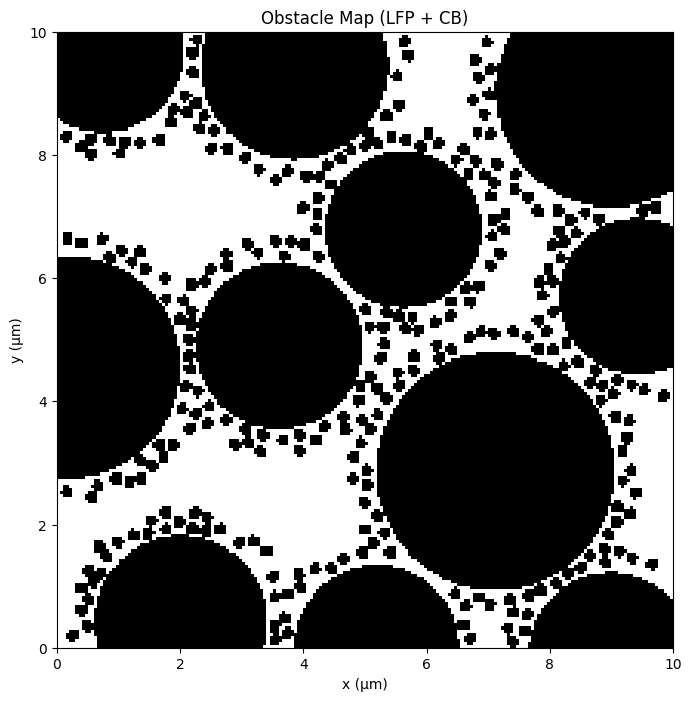

In [ ]:
 def generate_obstacle_map(domain_size, grid_size, lfp_positions, cb_positions, r_cb=0.1):
    grid_resolution = int(domain_size / grid_size)
    obstacle_map = np.zeros((grid_resolution, grid_resolution), dtype=int)

    def mark_obstacle(cx, cy, r):
        for i in range(grid_resolution):
            for j in range(grid_resolution):
                x = i * grid_size + grid_size / 2
                y = j * grid_size + grid_size / 2
                if np.hypot(cx - x, cy - y) <= r:
                    obstacle_map[i, j] = 1

    for lx, ly, lr in lfp_positions:
        mark_obstacle(lx, ly, lr)
    for cx, cy in cb_positions:
        mark_obstacle(cx, cy, r_cb)

    return obstacle_map

# 예시 사용
grid_size = 0.05
obstacle_map = generate_obstacle_map(domain_size, grid_size, lfp_positions, cb_positions)

plt.figure(figsize=(8, 8))
plt.imshow(obstacle_map.T, origin='lower', cmap='Greys', extent=[0, domain_size, 0, domain_size])
plt.title("Obstacle Map (LFP + CB)")
plt.xlabel("x (μm)")
plt.ylabel("y (μm)")
plt.grid(False)
plt.show()

In [ ]:
import numpy as np

# 출력 옵션을 설정하여 배열의 모든 값을 표시
np.set_printoptions(threshold=np.inf)  # 무한대로 설정하여 배열을 모두 출력

# 배열 출력
print(obstacle_map)


[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 

In [ ]:
import numpy as np
obstacle_map = array
# 장애물이 없는 곳의 인덱스를 찾기
free_space = np.where(obstacle_map == 0)

# free_space는 x, y 인덱스 배열로 반환됩니다
x_free, y_free = free_space

# 이제 x_free, y_free는 리튬이온이 출발할 수 있는 (x, y) 좌표를 나타냅니다.


NameError: name 'array' is not defined

NameError: name 'x_free' is not defined

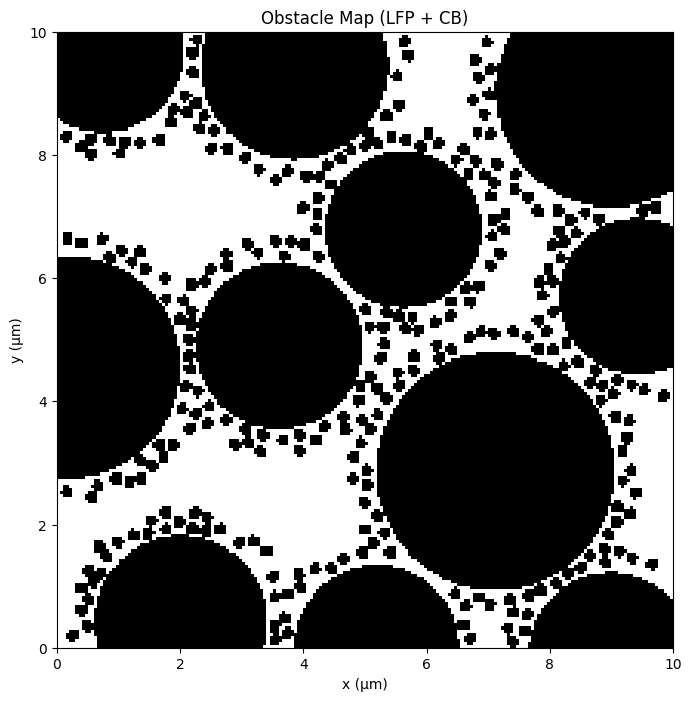

In [ ]:
domain_size = 10

plt.figure(figsize=(8, 8))
plt.imshow(obstacle_map.T, origin='lower', cmap='Greys', extent=[0, domain_size, 0, domain_size])
plt.title("Obstacle Map (LFP + CB)")
plt.xlabel("x (μm)")
plt.ylabel("y (μm)")

#유효한 경계 점 그리기
plt.scatter(x_free, y_free, color='red', s=1)

plt.legend()
plt.grid(False)
plt.show()

입자 배치는 요기까지 입니다~~~~